# Solving Street View House Numbers using CNN

Importing all necessary packages 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
import scipy.io as sio


SEED = 123                 # to be able to rerun the same NN
np.random.seed(SEED)
tf.random.set_seed(SEED)

np.set_printoptions(precision=4, suppress=True, floatmode='fixed') # options determine the way floating point numbers

%matplotlib inline

Using TensorFlow backend.


loading data and defining classes

In [2]:
train_data = sio.loadmat('dataset/train_32x32.mat')
test_data = sio.loadmat('dataset/test_32x32.mat')
extra_data = sio.loadmat('dataset/extra_32x32.mat')

X_train, y_train = train_data['X'], train_data['y']
X_test, y_test = test_data['X'], test_data['y']
X_extra, y_extra = extra_data['X'], extra_data['y']

classes = [0,1,2,3,4,5,6,7,8,9]
nb_classes = 10

print(X_train.shape, X_test.shape, X_extra.shape)

(32, 32, 3, 73257) (32, 32, 3, 26032) (32, 32, 3, 531131)


Working on data

In [3]:

# Transpose the image arrays
X_train, y_train = np.transpose(X_train,(3,0,1,2)), y_train[:,0]
X_test, y_test = np.transpose(X_test,(3,0,1,2)), y_test[:,0]
X_extra, y_extra = np.transpose(X_extra,(3,0,1,2)), y_extra[:,0]


# Merge train and extra data
X_train = np.concatenate([X_train, X_extra])
y_train = np.concatenate([y_train, y_extra])

# Normalize
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255


# print  shapes
print("Training Set", X_train.shape)
print("Test Set", X_test.shape)
print('')

# Calculate the total number of images
num_images = X_train.shape[0] + X_test.shape[0]
print("Total Number of Images", num_images)

Training Set (604388, 32, 32, 3)
Test Set (26032, 32, 32, 3)

Total Number of Images 630420


Quick visualization 

In [4]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [5]:

print(y_train[:4])
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train[:4]

[1 9 2 3]


array([[0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000],
       [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000],
       [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000],
       [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000]], dtype=float32)

Label 277870 is [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000]


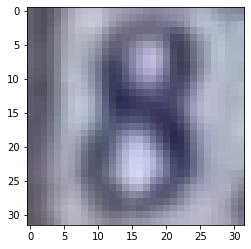

In [6]:
i = np.random.randint(1, len(X_train))
print("Label %d is" % i, y_train[i])
plt.imshow(X_train[i])

Building the model :
INPUT -> [CONV -> RELU -> POOL -> CONV -> RELU] -> FC -> softmax

In [7]:

model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=X_train[0].shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())                                          #flatten since too many dimensions, we only want a classification output
model.add(Dense(len(y_train[0]), activation='softmax'))       #output a softmax to squash the matrix into output probabilities

model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

a summary of the model

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                216330    
Total params: 291,978
Trainable params: 291,978
Non-trainable params: 0
_________________________________________________________________


and now training the model

In [9]:
model_history = model.fit(X_train, y_train, batch_size=128, epochs=2, validation_split = 0.1)

Train on 543949 samples, validate on 60439 samples
Epoch 1/2
543949/543949 [==============================] - 567s 1ms/step - loss: 0.3756 - accuracy: 0.8937 - val_loss: 0.1960 - val_accuracy: 0.9487
Epoch 2/2
543949/543949 [==============================] - 590s 1ms/step - loss: 0.2073 - accuracy: 0.9443 - val_loss: 0.1592 - val_accuracy: 0.9565


Evaluating the model by printing the test score and test accuracy

In [10]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0]) #loss
print('Test accuracy:', score[1])

Test score: 0.35662811776347225
Test accuracy: 0.9016211032867432


Visualize the prediction

In [11]:
res_test = model.predict(X_test)

In [12]:
# plotting Correctly classified results
res_test = pd.DataFrame({'true':np.argmax(y_test, axis=1), 'predict':np.argmax(res_test, axis=1), 'proba':np.max(res_test, axis=1)})
res_test.head(10)

,true,predict,proba
0,5,5,0.933889
1,2,2,0.998251
2,1,1,0.872147
3,0,0,0.951392
4,6,6,0.941568
5,1,1,0.797584
6,9,9,0.906839
7,1,1,0.996885
8,1,1,0.982326
9,8,8,0.997252


In [13]:
# plotting Misclassified results
errors = res_test[res_test.true != res_test.predict].sort_values('proba', ascending=False)
errors.head(10)

,true,predict,proba
15700,3,0,0.999999
1318,5,0,0.999973
4514,3,2,0.999963
3251,5,9,0.999942
6492,1,3,0.999940
8251,8,1,0.999873
3917,3,6,0.999812
23645,1,2,0.999766
1317,1,5,0.999482
4515,2,3,0.999424


In [14]:
print('Percentage of error %4.2f %%' % (100 * len(errors)/len(X_test))) 

Percentage of error 9.84 %


Prediction 

Image : 188
The Predicted is 1  
The real is 1
Stats are [[0.0000 0.9996 0.0000 0.0000 0.0002 0.0000 0.0000 0.0001 0.0000 0.0000]]


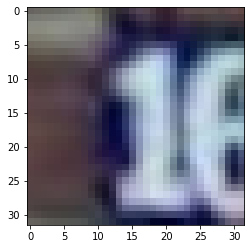

In [15]:
i = 188 
res = model.predict(X_train[i][None,:,:]) 
print("Image :", i)
print(f"The Predicted is {np.argmax(res)}  \nThe real is {np.argmax(y_test[i])}")
print("Stats are", np.array(res))
plt.imshow(X_test[i])

for saving the model

In [19]:
'''model.save('SVHN_models/SVHN_model-2-epochs.h5')'''

Loading saved model

In [17]:
'''import keras
from keras.models import load_model

# Recreate the exact same model purely from the file
new_model = keras.models.load_model('SVHN_models/SVHN_model.h5')'''

"import keras\nfrom keras.models import load_model\n\n# Recreate the exact same model purely from the file\nnew_model = keras.models.load_model('SVHN_model.h5')"

In [18]:
'''i = 1657 
res = new_model.predict(X_train[i][None,:,:]) 
print("Image :", i)
print(f"The Predicted is {np.argmax(res)}  \nThe real is {np.argmax(y_test[i])}")
print("Stats are", np.array(res))
plt.imshow(X_test[i])'''

'i = 1657 \nres = new_model.predict(X_train[i][None,:,:]) \nprint("Image :", i)\nprint(f"The Predicted is {np.argmax(res)}  \nThe real is {np.argmax(y_test[i])}")\nprint("Stats are", np.array(res))\nplt.imshow(X_test[i])'